<a href="https://colab.research.google.com/github/golumd/pythonHSE/blob/main/hw3_Petrov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение в машинное обучение

## НИУ ВШЭ

### Домашнее задание №3

### О задании

В этом домашнем задании вы реализуете решающее дерево и попрактикуетесь в решении задач классификации.

### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
\text{points} \times 10 / 14,
$$

где points — количество баллов за обязательную часть, которое вы набрали.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

Импортируйте все нужные вам функции ниже:

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from typing import Iterable, List, Tuple, Union
from collections import Counter
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 6.5)

# Решающее дерево своими руками (8 баллов + бонус)

В этой части для тестирования будем использовать датасет breast cancer. По предоставленной информации о ядрах клеток нужно предсказать присутствуют ли на изображении раковые клетки (класс 0) или нет (класс 1).

In [3]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(data=breast_cancer["data"], columns=breast_cancer["feature_names"])

# добавим искуственный категориальный признак
X['mean area cat'] = pd.qcut(X['mean area'], 5, labels=['smallest','small','medium','big', 'largest']).astype('object') 

X["target"] = breast_cancer["target"]
X_train, X_test = train_test_split(X, test_size=0.25, random_state=42)
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,mean area cat,target
287,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915,medium,1
512,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,113.30,844.4,0.15740,0.3856,0.5106,0.20510,0.3585,0.11090,medium,0
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,...,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247,medium,1
446,17.75,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,0.05916,...,145.40,1437.0,0.14010,0.3762,0.6399,0.19700,0.2972,0.09075,largest,0
210,20.58,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,...,158.30,1656.0,0.11780,0.2920,0.3861,0.19200,0.2909,0.05865,largest,0


### 1. Оцениванием качество разбиения (1 балл)

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

Используйте функции для подсчета значения критерия ошибки, а также для разбиения вершины из семинара:

In [4]:
def split_node(R_m: np.ndarray, feature: str, t: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Split a fixed set of objects R_m with given feature name and threshold t
    """
    mask = R_m[feature] <= t
    R_l = R_m.loc[mask]
    R_r = R_m.loc[~mask]
    return R_l, R_r


def q_error(R_m: np.ndarray, feature: str, t: float) -> float:
    """
    Compute error criterion for the given objects R_m, feature name and threshold t
    """
    R_l, R_r = split_node(R_m, feature, t)
    return  len(R_l) / len(R_m) * H(R_l['target']) + len(R_r) / len(R_m) * H(R_r['target'])

__(0.5 балла)__ Реализуйте функцию для вычисления критерия информативности. На семинаре мы рассматривали решающее дерево для регрессии и в качестве критерия качества разбиения использовали дисперсию целевой переменной. Для классификации лучше использовать другие критерии, например энтропию:

$$H(R) = -p_0\log_{2}{p_0} -p_1\log_{2}{p_1},$$ где $p_1$, $p_0$ — доля объектов среди $R$, которые относятся к классу 1 и 0 соответственно.

In [248]:
def H(y: np.ndarray) -> float:
    """
    Compute entropy for vector y with classes of objects R
        
    """
    y = list(y)
    if len(y) == 0:
      return 0
    p0, p1 = y.count(0)/len(y), y.count(1)/ len(y)
    #print(p0, p1)

    if p0*p1 != 0:
      entropy = -p0*np.log2(p0) - p1*np.log2(p1)
    else:
      entropy = 1/float("+inf")


    return entropy
print(H([0,0,0,0,0,1]))
print(H([0,0,0,0,0,0]))

# Проверяем на простых примерах
assert np.isclose(H([0,0,0,0,0,1]), 0.650022)
assert np.isclose(H([0,0,0,0,0,0]), 0)

0.6500224216483541
0.0


__(0.5 балла)__ Выберите признак, который как вам кажется может быть полезен для предсказания и порог для него. Сравните значение критерия информативности для объектов выборки до разбиения и взвешенной суммы критериев информативности для объектов после разбиения ($Q(R_m,j,t)$). Какой можно сделать вывод?

In [128]:
#X['worst area'] 
# your code here
print(H(list(X['target'])))
H(list(X_train['target']))*0.75+H(list(X_test['target']))*0.25

0.9526351224018599


0.9526022749800508

In [129]:
# ВРОДЕ ЭТО ВЕРНОЕ РЕШЕНИЕ
tt = 880.8 
print(q_error(X, 'worst area', tt))
print(q_error(X_train, 'worst area', tt)*0.75 + q_error(X_test, 'worst area', tt)*0.25)

0.3924740276719886
0.3893777189783719


### 2. Ищем наилучшее разбиение (2 балла)

Теперь нужно найти наилучшее разбиение множества объектов $R_m$ в данной вершине, то есть такой порог $t$ для некоторого признака, где значение критерия ошибки $Q(R_m, j, t)$ минимально.

__(1 балл)__ Модифицируйте функцию *get_optimal_split* из семинара так, чтобы:
- Не было случаев, когда в одно из поддеревьев попадает 0 объектов 
- В качестве порога использовалось среднее двух различных соседних (при сортировке) значений признака 
- При одинаковых значениях критерия ошибки выбирался минимальный сплит 

__(Бонусные 0.5 балла)__ Перепешите функцию так, чтобы не использовались циклы.

In [262]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    """
    Find best split of objects R_m by feature and return minimal q_error (opt_q_error), best threshold (opt_threshold) and array of error criterions (Q_array)
        
    """
    Q_array = []
    feature_values = sorted(list(np.unique(R_m[feature])))
    #print(feature_values)
    opt_q_error = 1
    #Q_array.append(q_error(R_m, feature, feature_values[0]))
    #Q_array = (q_error(R_m, feature_values, t))

    for i in range(len(feature_values)-1):
      #В качестве порога использовалось среднее двух различных соседних (при сортировке) значений признака
      t = (feature_values[i] + feature_values[i+1])/2 
      qerror = q_error(R_m, feature, t)
      Q_array.append(qerror)
      #if qerror<opt_q_error:
        #opt_q_error = qerror
        #opt_threshold = feature_values[i]
    #Q_array.append(1)
    #Q_array.append(q_error(R_m, feature, feature_values[-1]))   
    Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
    
    minimum_id = np.argmin(Q_array)
    opt_threshold = feature_values[minimum_id]
    opt_q_error = Q_array[minimum_id]
    #if opt_threshold == min(feature_values) or opt_threshold == max(feature_values):
     # opt_threshold = None
    return opt_threshold, opt_q_error, Q_array

In [263]:
thr, qq, QQ = get_optimal_split(X_train, 'worst area')
print(thr, '\n\n', qq)
#display(len(QQ))
#display(len(np.unique(X_train['worst area'])))

880.8 

 0.4277153340683222


__(0.25 балла)__ Постройте график зависимости критерия ошибки от выбранного порога для того же признака что и в 1ом задании и отметьте точку где достигается минимум.

[223.6, 240.1, 242.2, 249.8, 259.2, 268.6, 270.0, 273.9, 274.9, 275.6, 284.4, 285.5, 295.8, 297.1, 300.2, 301.0, 302.0, 303.8, 314.9, 317.0, 328.1, 330.7, 331.6, 335.9, 349.9, 351.9, 353.6, 355.2, 357.1, 357.4, 359.4, 361.2, 362.7, 364.2, 366.1, 366.3, 374.4, 375.4, 376.5, 380.2, 380.5, 384.0, 384.9, 390.2, 392.2, 395.4, 396.5, 403.7, 407.5, 408.3, 410.4, 411.1, 412.3, 414.0, 421.1, 424.8, 433.1, 434.0, 435.9, 437.0, 437.6, 439.6, 440.0, 440.4, 447.1, 450.0, 452.3, 453.5, 458.0, 459.3, 466.7, 467.2, 467.6, 467.8, 470.0, 470.9, 472.4, 472.9, 473.8, 474.2, 475.8, 476.4, 478.6, 487.7, 489.5, 489.8, 495.1, 495.2, 496.2, 496.7, 503.0, 507.2, 508.1, 508.9, 510.5, 512.5, 513.1, 513.9, 514.0, 515.3, 515.9, 516.4, 516.5, 517.8, 520.5, 521.3, 521.5, 521.7, 522.9, 523.4, 523.7, 525.1, 527.2, 527.4, 527.8, 528.1, 529.9, 531.2, 533.1, 534.0, 542.5, 543.4, 543.9, 544.1, 544.2, 545.2, 545.9, 546.1, 546.7, 547.4, 547.8, 549.1, 549.8, 549.9, 551.3, 552.0, 553.6, 553.7, 554.9, 558.9, 562.0, 562.6, 564.1

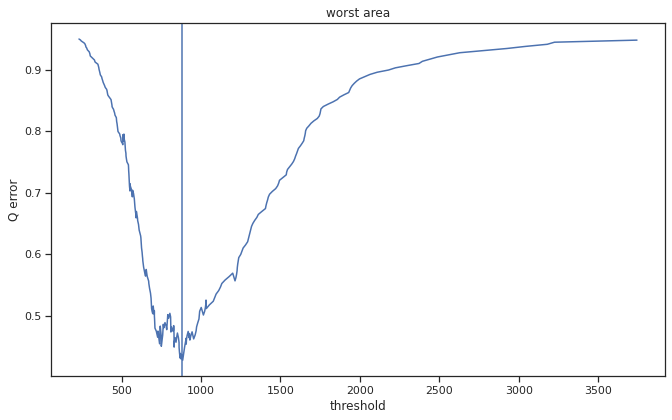

In [269]:
feature = 'worst area'
t, q_err, Q_array = get_optimal_split(X_train, feature)
t_uniqs = sorted(np.unique(X_train[feature]))
print(t_uniqs)
plt.plot([(t_uniqs[i]+t_uniqs[i+1])/2 for i in range(len(t_uniqs[:-1]))], Q_array)
#plt.plot(np.unique(X_train[feature][:-1]), Q_array) # здесь исключаем максимальную границу, чтобы не было деления на 0 
plt.title(feature)
plt.xlabel("threshold")
plt.ylabel("Q error")
plt.axvline(x=t)
plt.show()


__(0.75 балла)__ Найдите признак с минимальным значением критерия ошибки. Постройте на одном графике распределения значений этого признака для нулевого и первого класса (можно использовть seaborn) и добавьте прямую указывающую местоположение порога. 

In [25]:
qqs = 1
optimal_feature = 'target'
optimal_t = 0
cols = np.array(X.columns.drop(['mean area cat', 'target']))
for feat in cols:
  thr, qq, QQ = get_optimal_split(X_train, feat)
  if qq < qqs:
    qqs = qq
    optimal_feature = feat
    optimal_t = thr


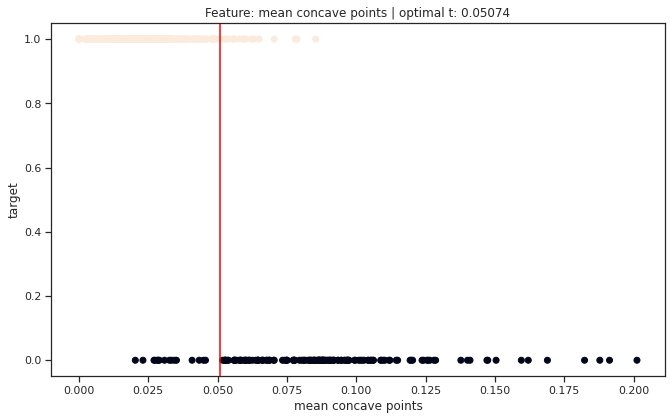

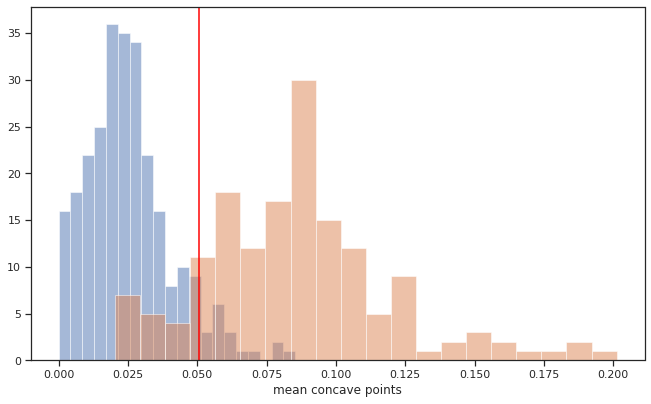

In [26]:
plt.scatter(X_train[optimal_feature], X_train['target'], c=X_train['target'])
plt.axvline(x=optimal_t, color="red")
plt.xlabel(optimal_feature)
plt.ylabel("target")
plt.title("Feature: {} | optimal t: {}".format(optimal_feature, optimal_t))
plt.show()

plt.xlabel(optimal_feature)
plt.axvline(x=optimal_t, color="red")
plt.hist(X_train[optimal_feature][X_train['target']==1], bins=20, alpha=0.5)
plt.hist(X_train[optimal_feature][X_train['target']==0], bins=20, alpha=0.5)
plt.show()

### 3. Строим дерево (5 баллов)

Теперь можно реализовать алгоритм целиком. Начинаем строить дерево с корня. В корне дерева находится вся обучающая выборка. Затем используем жадный алгоритм:

0. Проверяем критерий остановки - все элементы в вершине относятся к одному классу, ни по одному признаку нельзя разбить выборку, достигнута максимальная глубина дерева и пр.

1. Cреди всех признаков выбираем признак с минимальным значением критерия ошибки.

2. Разбиваем выборку на две подвыборки по наилучшему порогу для этого признака и из этих подвыборок получаем две новые дочерние вершины. 

3. Для каждой из них рекурсивно потворяем аналогичные действия.

__(3 балла)__ Заполните пропущенные строчки в функции __fit_node_ и реализуйте функцию __predict_node_.

In [270]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None
    ) -> None:
        
        if np.any(list(map(lambda x: x not in ('int64', 'float64', 'object'), feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой ("terminal" или "nonterminal"). Листовые вершины хранят значение класса для предсказания, 
        # нелистовые - правого и левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {"depth":0}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(
        self, 
        sub: pd.DataFrame, # подмножество объектов для данной вершины
        node: dict        # словарь для хранения информации о вершине
    ) -> None:
        
        # критерий остановки - проверяем что не все классы объектов в данной вершине одинаковы
        if np.all(sub['target'] == sub['target'].iloc[0]):
            node["type"] = "terminal"
            node["class"] = sub['target'].iloc[0]
            return
        
        
        # ищем лучший признак для разбиения
        feature_best, threshold_best, q_best = None, None, None
        for feature in sub.columns[:-1]:
            feature_type = self._feature_types[feature]
              
            # ищем оптимальный порог для текущего признака
            threshold, q, q_array = get_optimal_split(sub, feature)
            # your code here
            q_best = min(sub['target'].value_counts(normalize=True))
            if q<q_best:
              q_best = q
              threshold_best = threshold
              feature_best = feature
            

            
        # выбираем класс для листовой вершины
        if feature_best is None or node["depth"] == self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub['target']).most_common(1)[0][0]
            return
        
        # записываем полученное разбиение в атрибуты класса
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best
        sub_l, sub_r = split_node(sub, feature_best, threshold_best)
    
        # запускаем рекурсию
        node["left_child"], node["right_child"] = {"depth": node["depth"]+1}, {"depth": node["depth"]+1}
        self._fit_node(sub_l, node["left_child"])
        self._fit_node(sub_r, node["right_child"])

    def _predict_node(self, x: pd.Series, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: pd.Series, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
          return node["class"]
        
        feat = node["feature_split"]
        tr = node["threshold"] 
        if x[feat] <= tr: # "<=" т.к так определено в сплите (опр выше)
          return self._predict_node(x, node['left_child'])
        else:
          return self._predict_node(x, node['right_child'])
        # your code here
        

    def fit(self, X: pd.DataFrame, y: np.ndarray) -> None:
        X['target'] = y
        self._fit_node(X, self._tree)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        predicted = []
        for ind, x in X.iterrows():
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

__(1 балл)__ Обучите решающее дерево на обучающей части датасета (исключив колонку "mean area cat") и сравните accuracy полученную на обучающей и тестовой части. Совпадают ли топовые признаки с минимальным значением ошибки из предпредыдущего задания с признаками по которым произошли разбиения в дереве?

In [232]:
X.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [272]:
df_dtr_train = X_train.copy().drop(['mean area cat'], axis=1)
df_dtr_test = X_test.copy().drop(['mean area cat'], axis=1)
df_dtr_dtypes = df_dtr_train.dtypes
dtr = DecisionTree(feature_types=df_dtr_dtypes)
dtr.fit(df_dtr_train.drop(['target'], axis=1), df_dtr_train['target'])
#dtr.score(df_dtr_test.drop(['target'], axis=1), df_dtr_test['target'])
print(accuracy_score(dtr.predict(X_test.drop(['target'], axis=1)), df_dtr_test['target'])) 

0.6223776223776224


__(1 балл)__ Как будет происходить разбиение в вершине дерева по категориальному признаку? Является ли оно эффективным? Исправьте одну из функций выше так, чтобы дерево не выдавало ошибку при обучении на датасете с категориальными признаками. 

# Практическая часть (6 баллов)

__(2 балла)__ В этом задании нужно для того же датасета обучить несколько алгоритмов с помощью кросс-валидации и сравнить их качество по ROC AUC, accuracy и f1-score. Не забудьте удалить дополнительные колонки, которые были добавлены ранее.

1. Обучите и нарисуйте решающее дерево c глубиной 3. Настройте font_size или общий размер графика чтобы названия признаков были читабельны. Сравните его с деревом, которое вы написали самостоятельно. Для решающего дерева подберите оптимальный max_depth и min_samples_split по выбранной метрике.

2. Обучите логистическую регрессию c L2 регуляризацией и подберите для нее наилучший параметр.

3. Обучите SVM и выберите наиболее подходящее ядро и параметр регуляриации.


Выберите метрику, по которой вы будете выбирать наилучшие параметры. Почему для этого датасета стоит сравнивать предсказания не только по значению accuracy? Что важнее для этой задачи - оптимизировать precision или recall? 

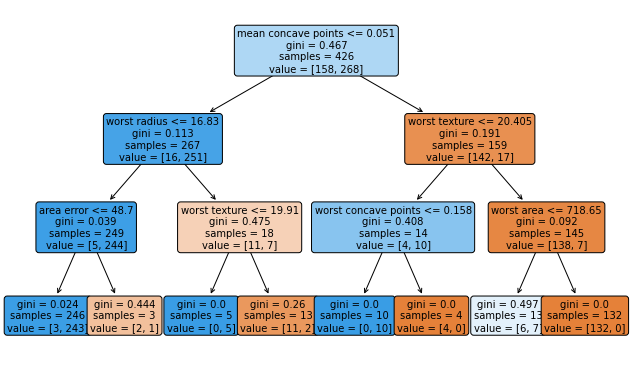

In [156]:
X, X_train, X_test = X.drop(['mean area cat'], axis = 1), X_train.drop(['mean area cat'], axis = 1), X_test.drop(['mean area cat'], axis = 1) 
dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train.drop(['target'], axis=1), X_train['target'])
plot_tree(dtree, feature_names=X.drop(['target'], axis=1).columns, filled=True, rounded=True, fontsize=10)
plt.show()

Теперь загрузим еще один [датасет](https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification). По данным о клиентам банка нужно предсказать будет ли клиент брать кредит на длительный срок или нет. И если да, то сотрудники банка позвонят и предложат ему кредит. 

In [216]:
df = pd.read_csv('new_train.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


__(0.5 балла)__ Изучите и подготовьте данные - проверьте типы колонок, соотношение классов, наличие пропусков (пропуски для категориальных переменных указаны как 'unknown'), повторяющихся объектов, проверьте частоты значений признаков и их смысл - возможно какие-то признаки можно удалить. 

In [ ]:
for i in list(df.columns):
  print(df[i].value_counts(), end='\n\n')

Из результатов выше видно, что столбец "default" в основе своей заполнен одним значением или значение вовсе отсутствует.

Можно кикнуть.

In [217]:
df = df.drop('default', axis=1)

In [ ]:
df.info()

In [218]:
import statistics as stc 
cols = df.columns
num_cols = list(df._get_numeric_data().columns)
obj_cols = list(cols.drop(num_cols)) #.drop('y')
print(cols)
print(num_cols)
print(obj_cols)
for i in list(obj_cols):
  df[i][df[i]=='unknown'] = stc.mode(df[i])
  print(stc.mode(df[i]))

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y'],
      dtype='object')
['age', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
admin.
married
university.degree
yes
no
cellular
may
thu
nonexistent
no


In [ ]:
for i in obj_cols:
  print(df[i].value_counts(), end='\n\n')

In [100]:
print(cols)
print(num_cols)
print(obj_cols)

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y'],
      dtype='object')
Index(['age', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')
Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome', 'y'],
      dtype='object')


__(0.5 балла)__ Постройте графики с распределениями по каждому из категориальных признаков. Статистики должны быть выведены для обоих классов и либо расположены на одном графике, либо находиться на соседних графиках, чтобы можно было сравнить их между собой. Вам поможет plt.subplot(s) если вы используете matplotlib или продвинутые функции из seaborn, позволяющие автоматически строить сразу несколько графиков. Убедитесь что на графиках подписаны оси, все надписи читабельны и пр. Проанализируйте полученные результаты.

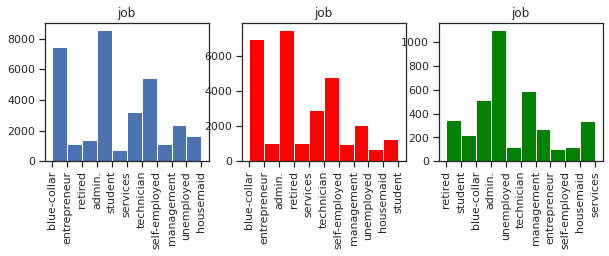

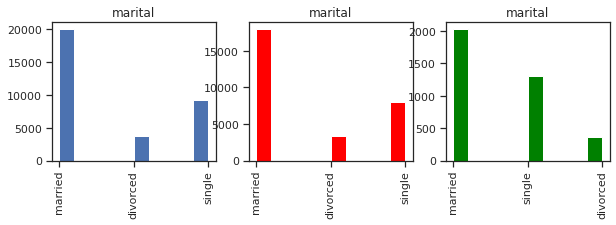

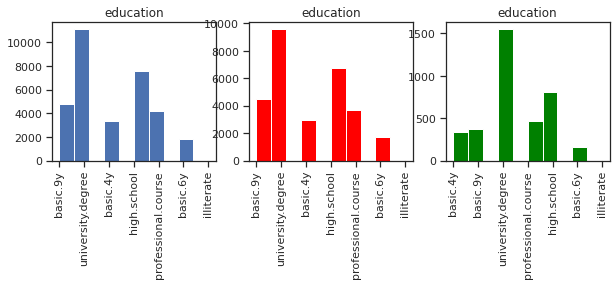

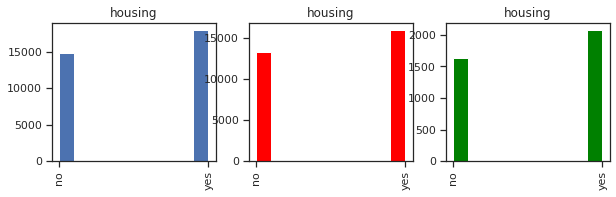

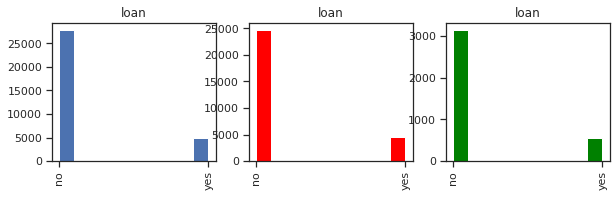

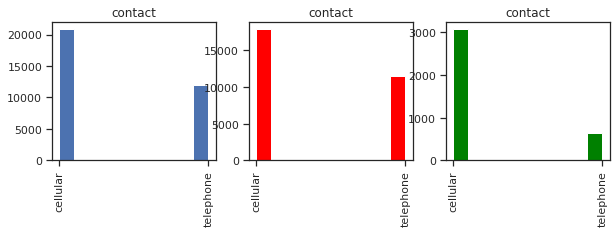

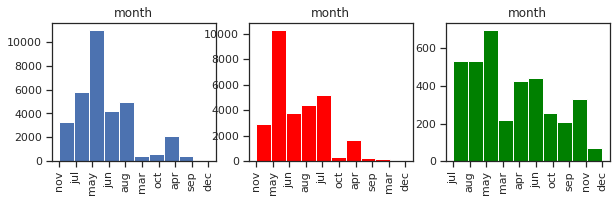

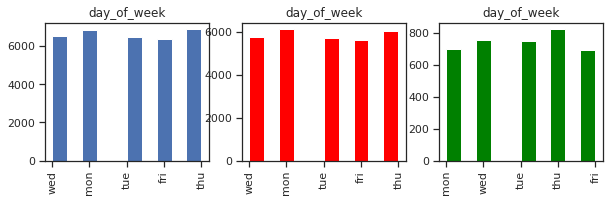

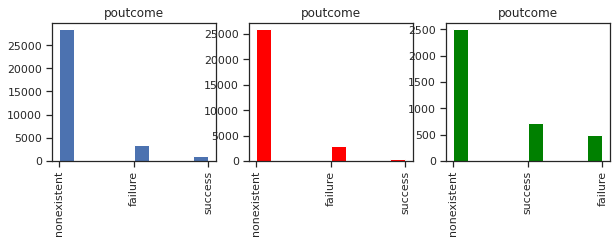

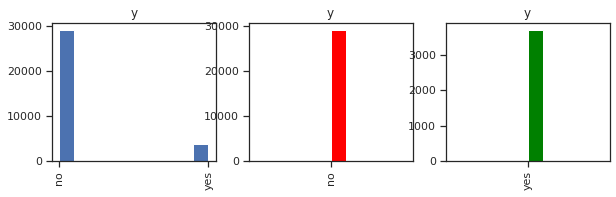

In [188]:
obj_count = len(obj_cols)
#plt.subplot([2, (obj_count-1)//2+1, ])

for i in range(obj_count):
  plt.figure(figsize=(10, 30))
  #plt.subplot((obj_count-1)//2+1, 2, i+1)
  plt.subplot(obj_count, 3, 3*i+1)
  plt.hist(df[obj_cols[i]])
  plt.title(obj_cols[i])
  plt.xticks(rotation=90)

  plt.subplot(obj_count, 3, 3*i+2)
  plt.hist(df[df['y']=='no'][obj_cols[i]], color = 'red', alpha=1)
  plt.title(obj_cols[i])
  plt.xticks(rotation=90)

  plt.subplot(obj_count, 3, 3*i+3)
  plt.hist(df[df['y']=='yes'][obj_cols[i]], color = 'green', alpha=1)
  plt.title(obj_cols[i])
  plt.xticks(rotation=90)
plt.show()

__(0.5 балла)__ Проведите анализ числовых признаков - постройте попарные графики для признаков и график с корреляцией Пирсона.

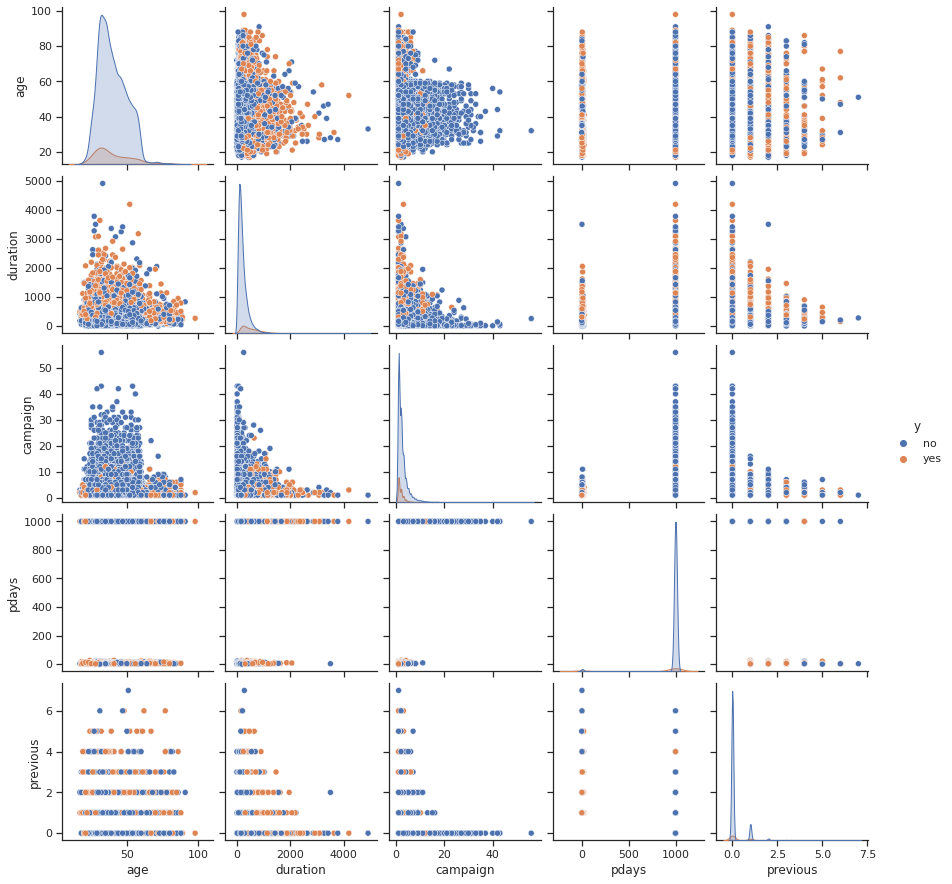

In [189]:
import seaborn as sns
sns.set_theme(style="ticks")

#df = sns.load_dataset("penguins")
sns.pairplot(df, hue='y')
plt.show()

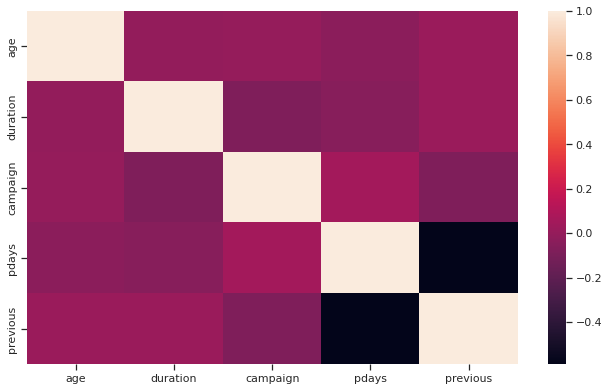

In [190]:
num_cols_y = num_cols + ['y']
sns.heatmap(df[num_cols_y].corr())
plt.show()

__(0.5 балл)__ Преобразуйте категориальные признаки. Подумайте какие признаки лучше закодировать с помощью one-hot encoding, а какие с помощью label-encoding.

In [180]:
for i in obj_cols:
  print(f'{i}: ', np.unique(df[i]))

job:  ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed']
marital:  ['divorced' 'married' 'single']
education:  ['basic.4y' 'basic.6y' 'basic.9y' 'high.school' 'illiterate'
 'professional.course' 'university.degree']
housing:  ['no' 'yes']
loan:  ['no' 'yes']
contact:  ['cellular' 'telephone']
month:  ['apr' 'aug' 'dec' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
day_of_week:  ['fri' 'mon' 'thu' 'tue' 'wed']
poutcome:  ['failure' 'nonexistent' 'success']
y:  ['no' 'yes']


0: 10
1: 20
2: 30


-------
### OHE:
job, marital, contact, poutcome

--------

### LABEL:
education, housing, loan, month, day_of_week, y

-------

In [219]:
from sklearn.preprocessing import LabelEncoder
ohe_cols = ['job', 'marital', 'contact', 'poutcome']
df_ohe = df.copy()
print(list(df_ohe.columns))

df_ohe = pd.get_dummies(df_ohe[ohe_cols], prefix=ohe_cols)

#for i, col in enumerate(ohe_cols):
  #df_ohe = pd.get_dummies(df_ohe, col, prefix=)
  #df_ohe = df_ohe.drop(i, axis=1)
print(df_ohe.columns)


['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success'],
      dtype='object')


In [221]:
le = LabelEncoder()
le_cols = ['education', 'housing', 'loan', 'month', 'day_of_week', 'y']
for i in le_cols:
  df_ohe[i] = le.fit_transform(df[i])


In [222]:
print(df_ohe.columns)

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'education', 'housing', 'loan', 'month',
       'day_of_week', 'y'],
      dtype='object')


In [223]:
df_ohe

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,education,housing,loan,month,day_of_week,y
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,2,0,0,7,4,0
1,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,6,0,0,7,4,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,3,1,1
3,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,6,1,0,6,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,6,0,0,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,3,1,0,3,3,0
32946,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,5,1,0,7,0,0
32947,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,2,0,1,3,1,0
32948,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,6,0,0,6,0,0


In [224]:
df_ohe = pd.concat([df_ohe, df[num_cols]], axis=1)

In [225]:
df_ohe

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,housing,loan,month,day_of_week,y,age,duration,campaign,pdays,previous
0,0,1,0,0,0,0,0,0,0,0,...,0,0,7,4,0,49,227,4,999,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,7,4,0,37,202,2,999,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,3,1,1,78,1148,1,999,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,6,1,0,36,120,2,999,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,4,3,0,59,368,2,999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,0,0,0,0,0,0,0,1,0,0,...,1,0,3,3,0,28,192,1,999,0
32946,0,0,0,0,0,0,0,0,0,1,...,1,0,7,0,0,52,64,1,999,1
32947,1,0,0,0,0,0,0,0,0,0,...,0,1,3,1,0,54,131,4,999,0
32948,1,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,29,165,1,999,0


__(1 балл)__ В этом датасете отношение между положительными примерами и отрицательными практически 1:8. Поэтому хорошей идеей будет сбалансировать датасет (oversampling - добавить элементы менее популярного класса на основе имеющихся или undersampling - наоборот убрать элементы более популярного класса. см. [imblearn](https://imbalanced-learn.org/stable/over_sampling.html#a-practical-guide)) или пропорционально изменить веса классов в самих моделях (параметр class_weight), а также использовать чувствительные к таким случаям метрики. 

Разбейте датасет на train и test, используйте параметр stratify, чтобы соотношение классов не изменилось после разбиения датасета на две части. Аналогично в дальнейшем при использовании кросс-валидации используйте версию функции сохраняющую соотношение классов (StratifiedKFold). 

Подберите параметры логистической регрессии и решающего дерева с помощью кросс-валидации по AUC PR (площадь под Precision-Recall кривой). Для тестовой части датасета выведите получившиеся значения AUC PR, f1-score, PR-кривую и выведите матрицы для истинных значений и предсказаний (confusion matrix). Их можно красиво вывести с помощью seaborn.heatmap(). На что стоит больше обращать внимание - на ошибку первого или второго рода?

__(0.5 балла)__ Рассмотрим задачу с точки зрения прибыли для банка. Маркетинговая компания требует значительных финансовых затрат, и ее эффективность напрямую зависит от качества нашей модели. Поэтому в качестве дополнительной метрики качества разумно использовать общую прибыль банка в той или иной форме. Мы будем рассматривать очень простую модель. Пусть каждый клиент после возврата всех процентов по кредиту (и с учетом всех расходов на обслуживание) приносит банку в среднем 10000 у.е., затраты на привлечение одного клиента составляют 100 у.е. Тогда сколько составит прибыль банка (доходы - расходы) если работники банка свяжутся со всеми клиентами, которых предсказала наша лучшая модель как подходящих на тестовой части и они все согласятся открыть кредит? Сколько составят расходы на маркетинг? В данной модели мы не учитываем что кредит может быть не возвращен в срок.

__(0.5 балла)__ Снова используйте кросс-валидацию с пятью подвыборками. Обучите логистическую регрессию и выведите пять значений прибыли, а также подсчитайте среднее значение. Постройте графики зависимости среднего значения прибыли и AUC PR от параметра регуляризации.